Hunter Bennett  
Glass Lab  
DESeq investigation of liver strain ATAC data  
Created 180103 | Last updated 180104
_____
The goal of this analysis is to explore the ATAC data and try to understand why we return so few differential peaks when we analyze it with DESeq2

In [3]:
# load DESeq2
library(DESeq2)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Warning message:


In [4]:
# load in files prepared by python worklflow in the notebook 180103_ATAC_DiffPeaks
outdir = '/home/h1bennet/liverStrains/results/180103_ATAC/'
col_data = read.csv(paste0(outdir, 'deseq_col_data.txt'), sep='\t')
atac_counts = read.csv(paste0(outdir, 'deseq_atac_counts.txt'), sep='\t', row.names=1)

In [5]:
# clean up the column names
colnames(atac_counts) <- lapply(strsplit(colnames(atac_counts), '\\.'), `[[`, 6)

# set baseline levels for the categories we will use in our model
col_data$diet <- relevel(col_data$diet, ref='control')
col_data$strain <- relevel(col_data$strain, ref='ncorwt')


In [6]:
library(data.table)
# it turns out that the chrM chromosome is mapping only in aj and Balb, this seems to really
# mess up DESeqs variance stabilization and downstream analysis, lets fix this here...
dim(atac_counts[!(rownames(atac_counts) %like% 'chrM'), ])
atac_counts <- atac_counts[!(rownames(atac_counts) %like% 'chrM'), ]


Attaching package: ‘data.table’

The following object is masked from ‘package:SummarizedExperiment’:

    shift

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked from ‘package:IRanges’:

    shift

The following objects are masked from ‘package:S4Vectors’:

    first, second



[1] 69405    12

### Run DESeq analysis with interaction term model

In [7]:
dds <- DESeqDataSetFromMatrix(countData = atac_counts,
                             colData = col_data,
                             design = ~ strain + diet + strain:diet)

converting counts to integer mode


In [8]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Lets look at the mean-variance relationship in the data

In [163]:
vsd <- vst(dds, blind=FALSE)
rld <- rlog(dds, blind=FALSE)

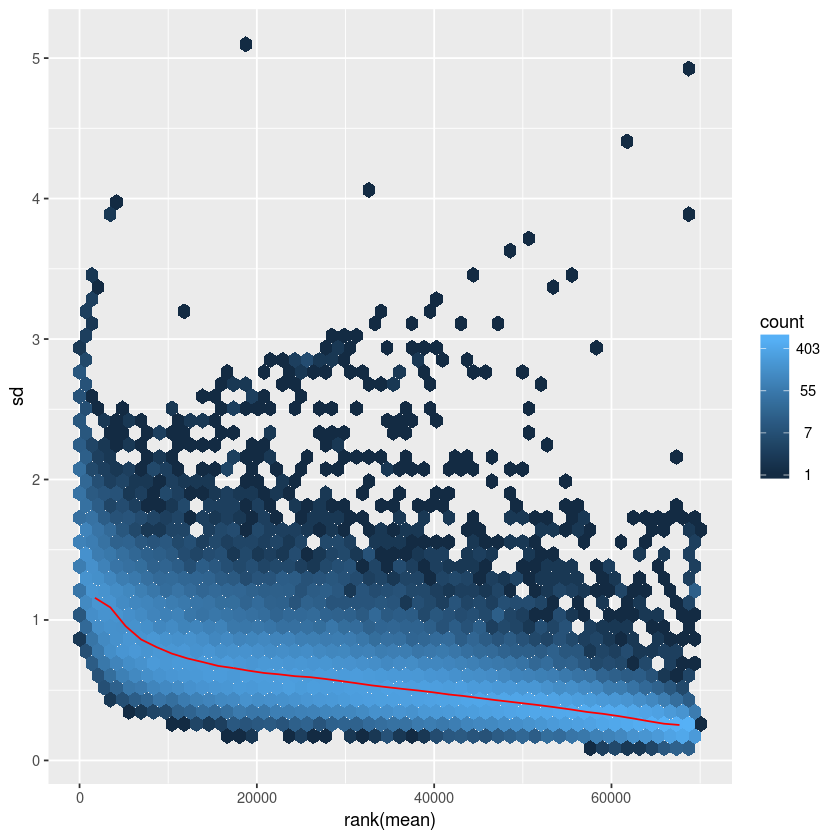

In [164]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library("vsn")
meanSdPlot(assay(ntd))

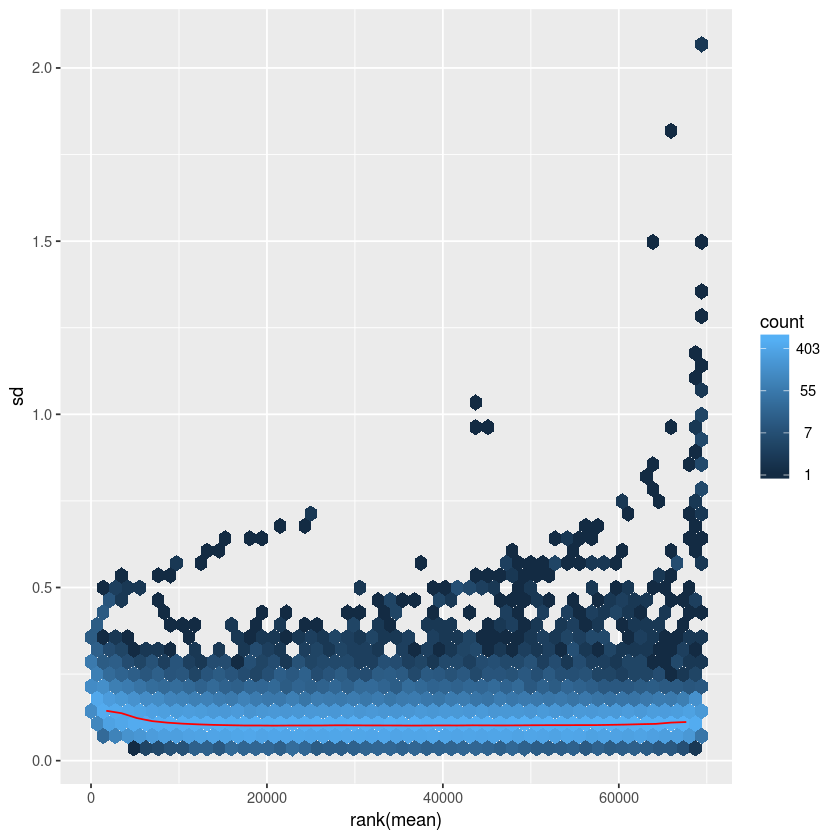

In [165]:
meanSdPlot(assay(vsd))

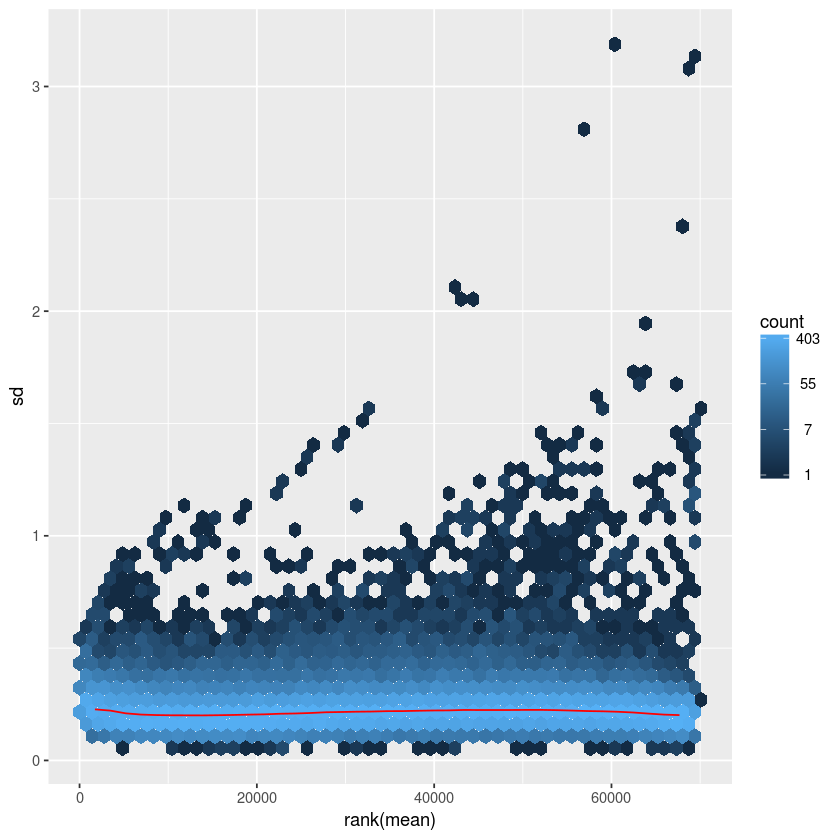

In [166]:
meanSdPlot(assay(rld))

### Look at some distance metrics of the data (heatmap, PCA)

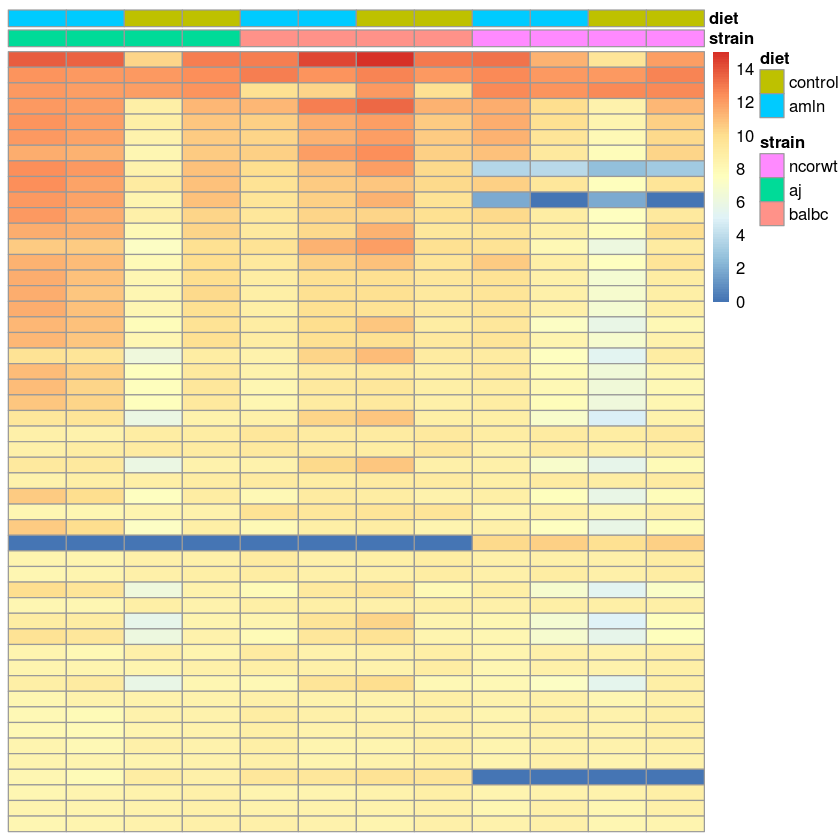

In [169]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:50]
df <- as.data.frame(colData(dds)[,c("strain","diet")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         show_colnames=FALSE, cluster_cols=FALSE, annotation_col=df)

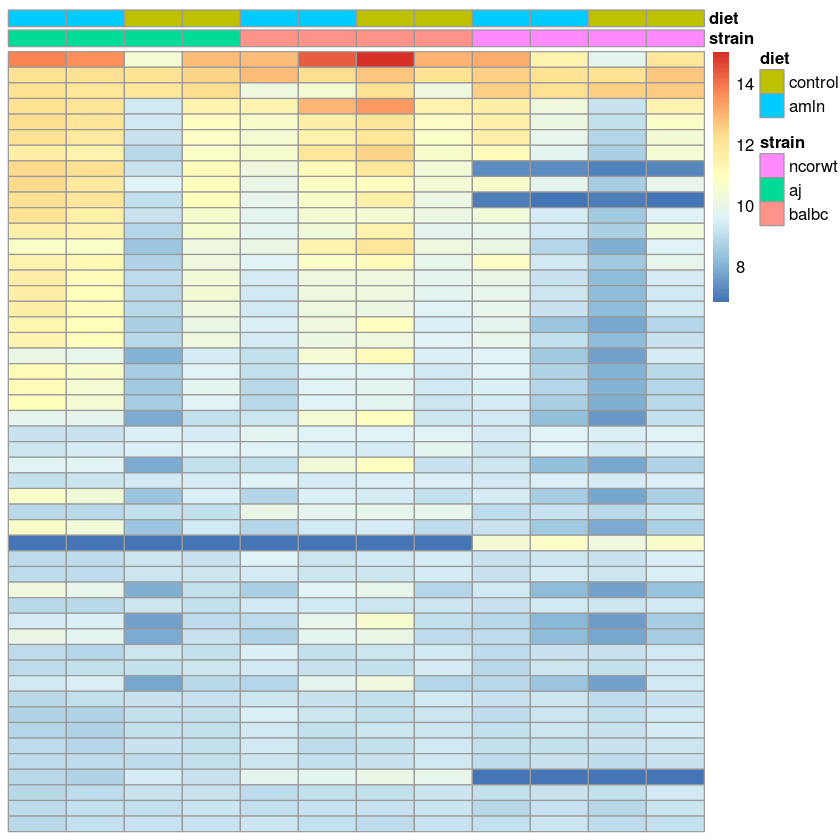

In [170]:
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE, show_colnames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

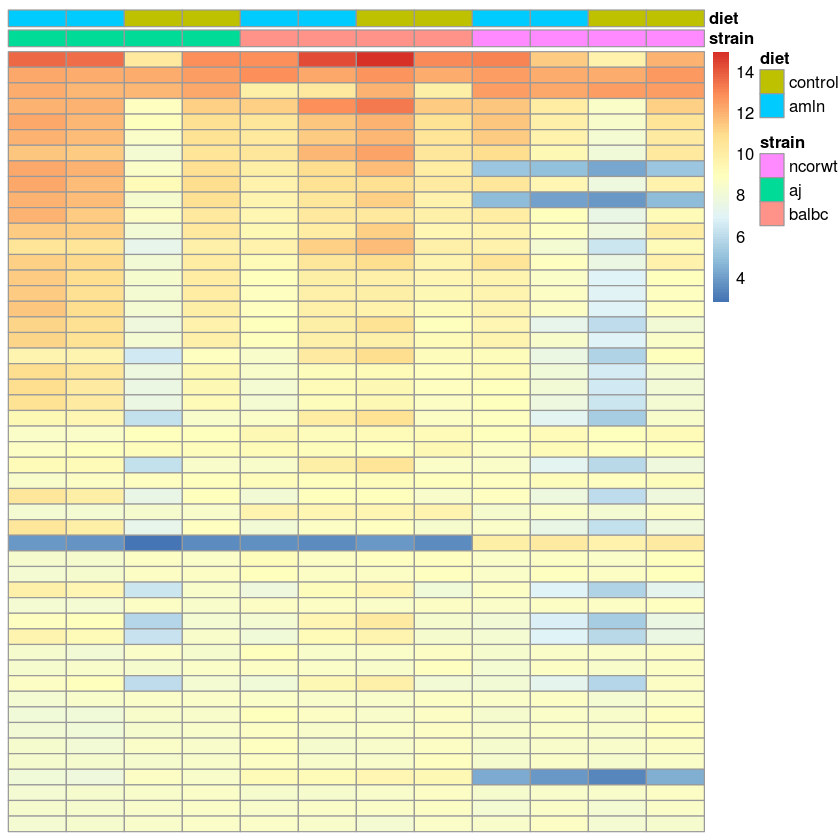

In [171]:
pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE, show_colnames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

### Lets take a look at the sample distances...

In [172]:
sampleDists <- dist(t(assay(vsd)))

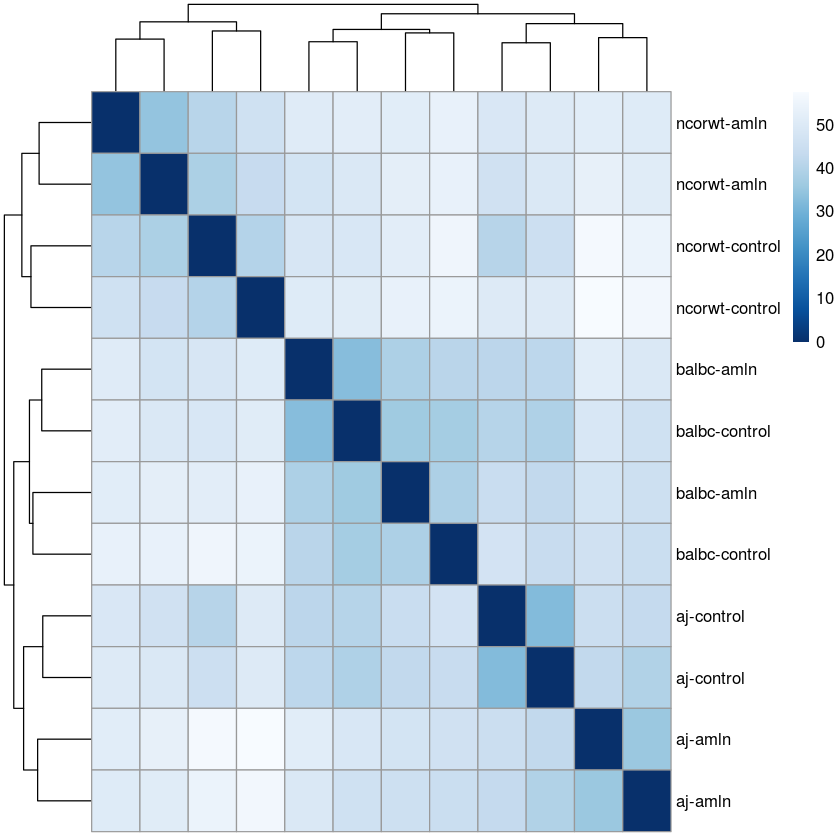

In [173]:
library("RColorBrewer")
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$strain, vsd$diet, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

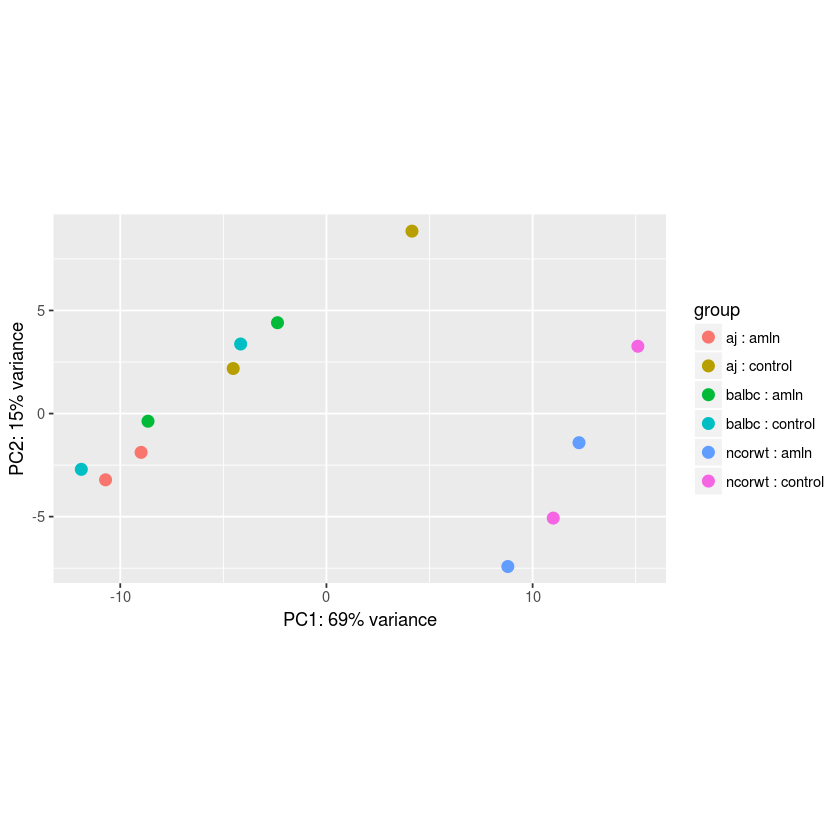

In [174]:
plotPCA(vsd, intgroup=c("strain", "diet"))


### Now we will do a differential gene analysis

In [7]:
# diet effect for ncorwt
res <- results(dds, contrast=c('diet', 'amln', 'control'), alpha = 0.1)
res_ordered <- res[order(res$padj), ]

In [8]:
summary(res)


out of 69405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 11, 0.016% 
LFC < 0 (down)   : 96, 0.14% 
outliers [1]     : 0, 0% 
low counts [2]   : 26912, 39% 
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [9]:
head(res_ordered)

log2 fold change (MLE): diet amln vs control 
Wald test p-value: diet amln vs control 
DataFrame with 6 rows and 6 columns
                          baseMean log2FoldChange     lfcSE      stat
                         <numeric>      <numeric> <numeric> <numeric>
Merged-chr5-41525682-3    28.34448      -3.153976 0.5827749 -5.411998
Merged-chr14-13551332-3   23.71684      -3.083443 0.5935128 -5.195243
Merged-chr10-10480981-5   31.24895      -3.112710 0.5990596 -5.195995
Merged-chr13-113949903-6  83.60901      -1.547068 0.3210469 -4.818824
Merged-chr12-46819514-4   55.66936      -2.278960 0.4718113 -4.830237
Merged-chr15-88515268-6   45.77261      -1.967457 0.4128016 -4.766107
                               pvalue        padj
                            <numeric>   <numeric>
Merged-chr5-41525682-3   6.232536e-08 0.002648392
Merged-chr14-13551332-3  2.044529e-07 0.002895939
Merged-chr10-10480981-5  2.036281e-07 0.002895939
Merged-chr13-113949903-6 1.444067e-06 0.007158076
Merged-chr12-4681

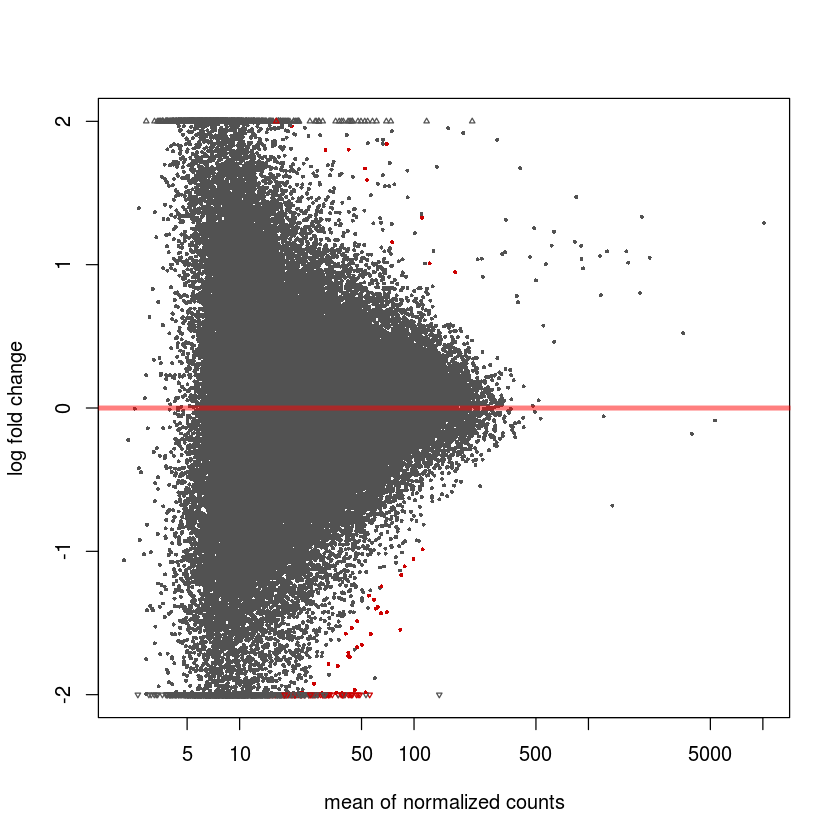

In [178]:
plotMA(res, ylim=c(-2,2))

In [10]:
# diet effect for balbc
res <- results(dds, contrast=list( c('diet_amln_vs_control','strainbalbc.dietamln') ), alpha = 0.1)
res_ordered <- res[order(res$padj), ]
summary(res)


out of 69405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [11]:
head(res_ordered)

log2 fold change (MLE): diet_amln_vs_control+strainbalbc.dietamln effect 
Wald test p-value: diet_amln_vs_control+strainbalbc.dietamln effect 
DataFrame with 6 rows and 6 columns
                                baseMean log2FoldChange     lfcSE        stat
                               <numeric>      <numeric> <numeric>   <numeric>
Merged-chr2-98667188-6        10150.7391     -0.5939140 1.1408593 -0.52058480
Merged-chr1-24613116-6         5319.7645      0.1663464 0.3341976  0.49774875
Merged-chr1-24612752-6         3918.4326     -1.2803981 0.5585298 -2.29244377
Merged-chr2-98662365-6         3498.4303     -0.4237214 1.1546884 -0.36695730
Merged-chr10-130594773-4       1692.7978     -0.7513291 0.8635063 -0.87009107
Merged-chrUn_JH584304-59717-2   425.1313     -0.1605607 2.0687337 -0.07761304
                                  pvalue      padj
                               <numeric> <numeric>
Merged-chr2-98667188-6        0.60265604 0.9999659
Merged-chr1-24613116-6        0.61866114 0.9

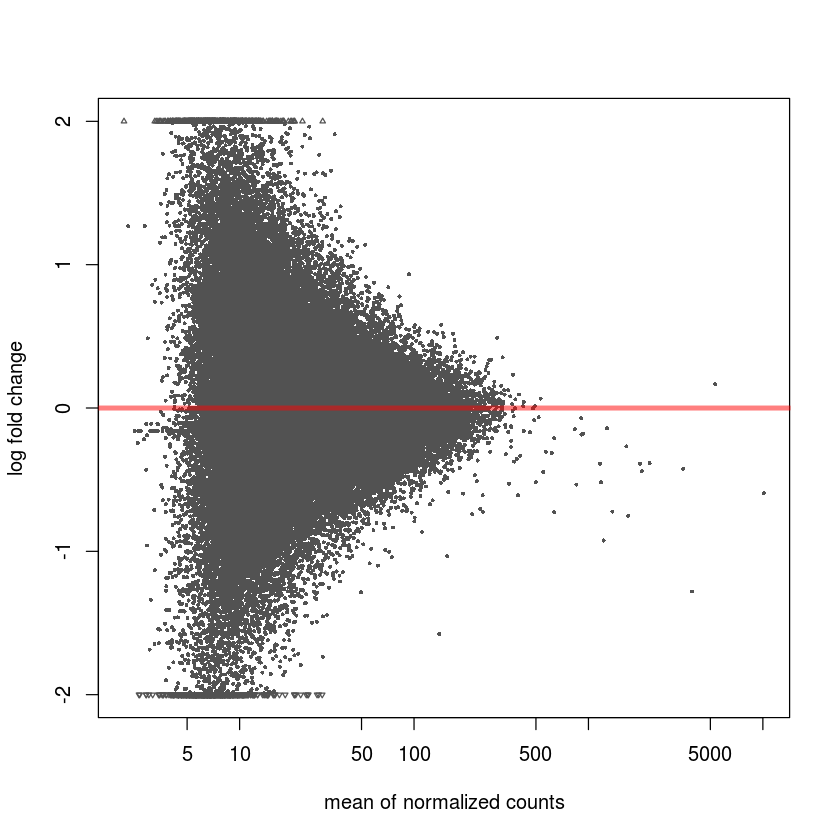

In [181]:
plotMA(res, ylim=c(-2,2))

In [12]:
res <- results(dds, contrast=list( c('diet_amln_vs_control','strainaj.dietamln') ), alpha = 0.1)
res_ordered <- res[order(res$padj), ]
summary(res)


out of 69405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 10, 0.014% 
LFC < 0 (down)   : 1, 0.0014% 
outliers [1]     : 0, 0% 
low counts [2]   : 48442, 70% 
(mean count < 29)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [13]:
head(res_ordered)

log2 fold change (MLE): diet_amln_vs_control+strainaj.dietamln effect 
Wald test p-value: diet_amln_vs_control+strainaj.dietamln effect 
DataFrame with 6 rows and 6 columns
                          baseMean log2FoldChange     lfcSE      stat
                         <numeric>      <numeric> <numeric> <numeric>
Merged-chr15-100935321-2 299.83271      1.7517965 0.4247101  4.124688
Merged-chr11-3174413-4   360.92675     -0.7102995 0.1699313 -4.179923
Merged-chr10-75170652-6   57.92456      1.6324074 0.3769868  4.330145
Merged-chr17-3082042-4    57.79105      1.6964397 0.3940374  4.305276
Merged-chr4-43493363-6    34.04155      1.6482572 0.4057843  4.061904
Merged-chr5-124483418-6   39.32911      1.7125876 0.3906110  4.384382
                               pvalue       padj
                            <numeric>  <numeric>
Merged-chr15-100935321-2 3.712379e-05 0.09456651
Merged-chr11-3174413-4   2.916084e-05 0.09456651
Merged-chr10-75170652-6  1.490112e-05 0.09456651
Merged-chr17-3082042-4

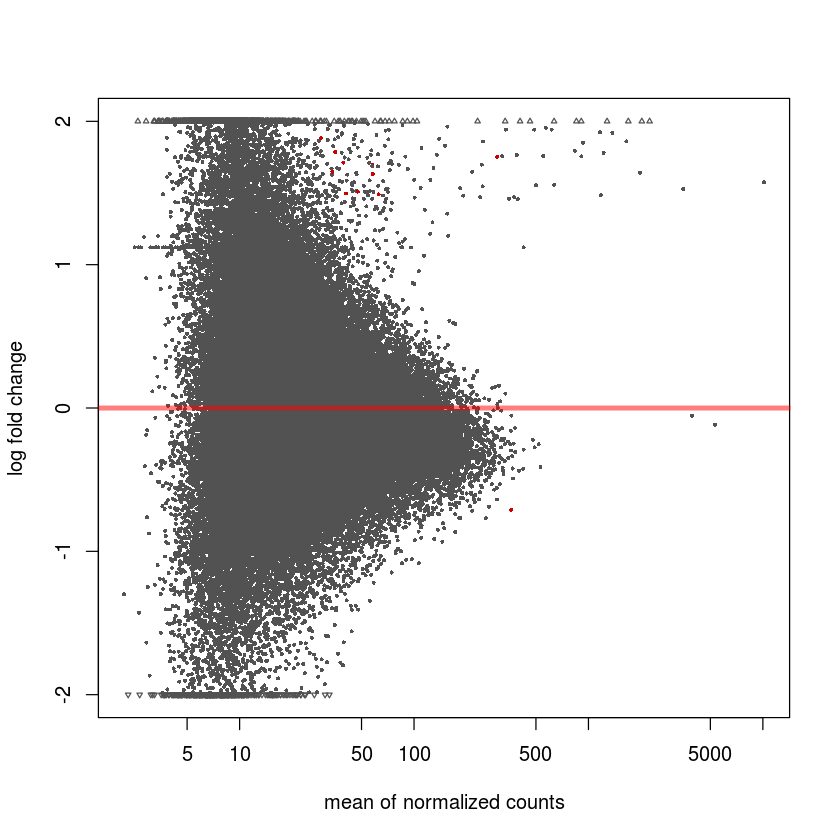

In [184]:
plotMA(res, ylim=c(-2,2))

### The interaction model didn't give many promising results
______
lets see if its just because of the data or because of the model by reanalyzing the data with a model without the interaction term

In [9]:
col_data$straindiet = as.factor(paste0(col_data$strain, '_', col_data$diet))
col_data$straindiet <- relevel(col_data$straindiet, ref='ncorwt_amln')

In [10]:
ddsRed <- DESeqDataSetFromMatrix(countData = atac_counts,
                             colData = col_data,
                             design = ~ straindiet)

converting counts to integer mode


In [11]:
ddsRed <- DESeq(ddsRed)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [12]:
resRed <- results(ddsRed, contrast=c('straindiet','ncorwt_amln','ncorwt_control'), alpha = 0.1)
resRed_ordered <- resRed[order(resRed$padj), ]
summary(resRed)


out of 69405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 11, 0.016% 
LFC < 0 (down)   : 96, 0.14% 
outliers [1]     : 0, 0% 
low counts [2]   : 26912, 39% 
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [13]:
head(res_ordered)

ERROR: Error in head(res_ordered): object 'res_ordered' not found


In [20]:
resRed <- results(ddsRed, contrast=c('straindiet','balbc_amln','balbc_control'), alpha = 0.1)
resRed_ordered <- resRed[order(resRed$padj), ]
summary(resRed)


out of 69405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [21]:
resRed <- results(ddsRed, contrast=c('straindiet','aj_amln','aj_control'), alpha = 0.1)
resRed_ordered <- resRed[order(resRed$padj), ]
summary(resRed)


out of 69405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 10, 0.014% 
LFC < 0 (down)   : 1, 0.0014% 
outliers [1]     : 0, 0% 
low counts [2]   : 48442, 70% 
(mean count < 29)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Looking at the AJ results from the full and reduced model... 

In [14]:
resRed <- results(ddsRed, contrast=c('straindiet','aj_amln','aj_control'), alpha = 0.1)
resRed_ordered <- resRed[order(resRed$padj), ]
write.csv(as.data.frame(resRed_ordered), 
          file=paste0(outdir, "/aj_amln_atac_red_deseq_results.txt"))
head(resRed_ordered)

log2 fold change (MLE): straindiet aj_amln vs aj_control 
Wald test p-value: straindiet aj_amln vs aj_control 
DataFrame with 6 rows and 6 columns
                          baseMean log2FoldChange     lfcSE      stat
                         <numeric>      <numeric> <numeric> <numeric>
Merged-chr15-100935321-2 299.83271      1.7517955 0.4247101  4.124685
Merged-chr11-3174413-4   360.92675     -0.7102997 0.1699313 -4.179924
Merged-chr10-75170652-6   57.92456      1.6324077 0.3769868  4.330145
Merged-chr17-3082042-4    57.79105      1.6964387 0.3940374  4.305273
Merged-chr4-43493363-6    34.04155      1.6482572 0.4057844  4.061904
Merged-chr5-124483418-6   39.32911      1.7125875 0.3906110  4.384381
                               pvalue       padj
                            <numeric>  <numeric>
Merged-chr15-100935321-2 3.712429e-05 0.09456675
Merged-chr11-3174413-4   2.916070e-05 0.09456675
Merged-chr10-75170652-6  1.490112e-05 0.09456675
Merged-chr17-3082042-4   1.667798e-05 0.09456675

In [16]:
res <- results(dds, contrast=list( c('diet_amln_vs_control','strainaj.dietamln') ), alpha = 0.1)
res_ordered <- res[order(res$padj), ]
summary(res)
write.csv(as.data.frame(resRed_ordered), 
          file=paste0(outdir, "/aj_amln_atac_deseq_results.txt"))
head(res_ordered)


out of 69405 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 10, 0.014% 
LFC < 0 (down)   : 1, 0.0014% 
outliers [1]     : 0, 0% 
low counts [2]   : 48442, 70% 
(mean count < 29)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): diet_amln_vs_control+strainaj.dietamln effect 
Wald test p-value: diet_amln_vs_control+strainaj.dietamln effect 
DataFrame with 6 rows and 6 columns
                          baseMean log2FoldChange     lfcSE      stat
                         <numeric>      <numeric> <numeric> <numeric>
Merged-chr15-100935321-2 299.83271      1.7517965 0.4247101  4.124688
Merged-chr11-3174413-4   360.92675     -0.7102995 0.1699313 -4.179923
Merged-chr10-75170652-6   57.92456      1.6324074 0.3769868  4.330145
Merged-chr17-3082042-4    57.79105      1.6964397 0.3940374  4.305276
Merged-chr4-43493363-6    34.04155      1.6482572 0.4057843  4.061904
Merged-chr5-124483418-6   39.32911      1.7125876 0.3906110  4.384382
                               pvalue       padj
                            <numeric>  <numeric>
Merged-chr15-100935321-2 3.712379e-05 0.09456651
Merged-chr11-3174413-4   2.916084e-05 0.09456651
Merged-chr10-75170652-6  1.490112e-05 0.09456651
Merged-chr17-3082042-4

In [19]:
resRed_ordered[resRed_ordered$padj <= 0.1]

ERROR: Error: logical subscript contains NAs


### Because of these results I think it will be wise to go back and compare these results with the results from the fully pairwise analysis using getDifferentialPeaks in HOMER to analyze peaks.
___
We need to visually examine the peaks from this analysis as well to see if DESeq2 is turning up promising leads.